# Dataframe Updater

This notebook is a demonstration of the Data Engineering that needs to go into the main dataframe in order to update this as new information comes in.

There are two main modes:

- Updating the dataframe with the actual results once I have them
- Inputting for the purposes of making predictions

** A note on this.  It is by no means perfect and I am working in my spare time to fine tune this process.  However, this is an example of that way I go about solving this problem.  This is very "code heavy" but please feel free to contact me if you would require a more detailed explanation**

** In addition, there are concerns over the intellectual property here so this worksheet is purely a demonstration of work that I have done in the past.  To validate this to an extent, I have run a model at the bottom and displayed the precision I can achieve for predicting the winners**

In [520]:
# Import Packages

import pandas as pd
import numpy as np

from datetime import timedelta

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
plt.style.use('ggplot')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from sqlalchemy import create_engine
engine = create_engine('postgresql://localhost:5432/danielpayne')

In [ ]:
crayford = pd.read_sql('SELECT * FROM crayford;', engine)

In [5]:
crayford = crayford.drop(['Unnamed: 0'], axis=1)

## Now attempt to update the main dataframe row by row

First I need to create the functions that can update my columns one row at a time. 

This means that I need to define these functions so that they will update each columns cell based on the name of the dog.

In [907]:
# Save dog_name dictionary
crayford_name_dict = {}
for name in crayford.name.unique():
    df = crayford.loc[crayford.name == name]
    crayford_name_dict[name] = df

In [726]:
# Define a function for the average time per dog per distance column.  
#Option to add an imputation in the future if needed


time_over_dist = crayford.groupby(['distance', 'name']).mean().time

def meantime_per_dog_over_dist(distance, name, imputation=0):
    try:
        return time_over_dist[distance, name]
    except:
        # Take the mean and add some time.  Crude imputation and fill for nan values
        return time_over_dist[distance].mean() + imputation

In [727]:
# Groupby table
grade_dist_ave_dog = crayford.groupby(['distance', 'grade', 'name']).mean().time

# create function to look up this number
def grade_dist_average_per_dog(distance, grade, name, imputation=0):
    try:
        return grade_dist_ave_dog[distance, grade, name]
    except:
        # Take the mean and add some time.  Crude imputation and fill for nan values
        return grade_dist_ave_dog[distance, grade].mean() + imputation

In [93]:
# Define a function for this grade or a better one.  
def better_or_equal_grade(grade):
    special = ["OR", "IV", "HP", "IT", "|"]
    letter = grade[0]

    possible_grades = [grade]
    
    if grade not in special:
        number = int(grade[1:])
        for x in range(1, number):
            possible_grades.append(letter + str(x))
    
    return possible_grades

In [728]:
# Create a function that gets the best time for each dog in grade for that race
def dog_best_time(date_time, grade, name):
    
    dog_df = crayford_name_dict[name]
    
    # Looping over the last month
    dog_df = dog_df.loc[(dog_df.date_time >= date_time - timedelta(days=31)) & 
                          (dog_df.date_time < date_time) & (dog_df.time > 0)]
    min_time = dog_df[dog_df['grade'].isin(better_or_equal_grade(grade))]['time'].min()
    return min_time

In [315]:
# Write function to measure mean of last 3 race results returning a Series object
def rolling_time(dist, name):
    df = crayford_name_dict[name]
    red_df = df.loc[df.distance == dist]
    red_df['mean_time'] = red_df['time'].rolling(window = 3, center=False).mean()
    try:
        return red_df.mean_time.iloc[-2]
    except:
        pass

mean_time(380, 'Sapphire Rose')

15.693333333333333

In [316]:
# Write function to measure mean of last n race results returning a Series object
def exp_time(dist, name):
    df = crayford_name_dict[name]
    red_df = df.loc[(df.distance == dist) & (df.time != -1)]
    red_df['exp_mean'] = pd.expanding_mean(red_df['time'])
    try:
        return red_df.exp_mean.iloc[-2]
    except:
        pass

exp_time(380, 'Sapphire Rose')

/Users/danielpayne/Anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.expanding_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.expanding(min_periods=1).mean()
/Users/danielpayne/Anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


24.039999999999999

In [185]:
# Write function to measure mean of last n race results 
def winning_form(dog_name, races):
    df = crayford_name_dict[dog_name]
    df['winning_form'] = df['winner'].rolling(window = races, center=False).mean()
    if pd.isnull(df.winning_form.iloc[-2]):
        return 0
    else:
        return df.winning_form.iloc[-2]

In [191]:
# Write function to measure mean of last n race results 
def positional_form_3(dog_name):
    df = crayford_name_dict[dog_name]
    df['pos_form_3'] = df['position'].rolling(window = 3, center=False).mean()
    return df.pos_form_3.iloc[-2]

In [192]:
# Write function to measure mean of last n race results 
def positional_form_5(dog_name):
    df = crayford_name_dict[dog_name]
    df['pos_form_5'] = df['position'].rolling(window = 5, center=False).mean()
    return df.pos_form_5.iloc[-2]

In [193]:
# Make function to measure trends
def trend_describer(dog_name, column):
    df = crayford_name_dict[dog_name]
    trend = df[column].iloc[-1] - df[column].iloc[-2]
        
    return trend

In [202]:
# Write function to measure mean of last n race results 
def section_form(dog_name):
    df = crayford_name_dict[dog_name]
    df['sec_form_3'] = df['section_position'].rolling(window = 3, center=False).mean()
    return df.sec_form_3.iloc[-2]

In [717]:
dist_ave = np.load('dist_ave.npy').item()
dist_ave

{60.0: nan,
 380.0: 24.247909609055192,
 540.0: 34.81310871183925,
 714.0: 46.56416949152544,
 874.0: 57.83166666666664}

In [960]:
# Function to make a new row
def df_updater(df, name, date, time_of_day, distance, grade, prize, trap_no, position=np.nan, time = np.nan,
              race_id = np.nan, comment = np.nan, odds = np.nan, going_allowance = np.nan, weight = np.nan,
              time_trap = np.nan, random = np.nan, trainer = np.nan, update = False):
    cols = ['date', 'datetime', 'distance', 'grade', 'prizes', 'trap_no']
    
    output_cols = ['name', 'grade', 'male','date', 'datetime', 'date_time', 'ave_dist_time', 'ave_time_per_dog_over_dist', 
                   'best_time_in_grade_currently', 'form_3', 'grade_dist_ave', 'grade_dist_ave_time_per_dog', 'positional_form_3', 
                   'mean_time_3_prev', 'new_exp_mean','positional_form_5', 'trend_3',  'trend_5',
                   'distance', 'section_form_3', 
                   'first_prize', 'born', 'trainer', 'track']
    
    update_cols = ['position', 'time', 'race_id', 'comment', 'odds', 'going_allowance', 'weight', 'time_trap']
    #new_cols = ['name'] + cols + update_cols
    
    new_cols = df.columns
    
    new_index = df.index.max()+1
    new_df = False
    try:
        df2 = crayford_name_dict[name]
        
    except:
        crayford_name_dict[name] = pd.DataFrame(columns=new_cols)
        df2 = crayford_name_dict[name]
        df2.loc[new_index] = np.nan
        new_df = True
    
    df2.loc[new_index, 'name'] = name
    df2.loc[new_index, cols] = date, time_of_day, distance, grade, prize, trap_no
        
        
    
    if update == True:
        # Look for any conditional inputs to be filled in
        if ((position == np.nan) & (time == np.nan) & (race_id == np.nan) & (comment == np.nan) 
            & (odds == np.nan) & (going_allowance == np.nan) & (weight == np.nan) & (time_trap == np.nan)):
            pass
        else:
            # Change the output of the function
           
            # Update the conditional columns
            #df2.loc[new_index, update_cols] = position, time, race_id, comment, odds, going_allowance, weight, time_trap
            
            df2.loc[new_index, 'position'] = position
            df2.loc[new_index, 'time'] = time
            df2.loc[new_index, 'race_id'] = race_id
            df2.loc[new_index, 'comment'] = comment
            df2.loc[new_index, 'odds'] = odds
            df2.loc[new_index, 'going_allowance'] = going_allowance
            df2.loc[new_index, 'weight'] = weight
            df2.loc[new_index, 'time_trap'] = time_trap
            df2.loc[new_index, 'trainer'] = trainer
            
            
            # Fill in the Male column 
            if (random == 'd ') | (random == 'd'):
                df2.loc[new_index, 'male'] = 1
            elif (random == 'b ') | (random == 'b'):
                df2.loc[new_index, 'male'] = 0
            else:
                pass
    else:
        pass
    
    if len(df2) == 1:
        pass
    else:
        df2['male'] = df2['male'].fillna(method='ffill')
        df2['trainer'] = df2['trainer'].fillna(method='ffill')
        df2['born'] = df2['born'].fillna(method='ffill')
    
    
    # Column transformed then converted to datetime
    date_time = (' ').join([date, time_of_day])
    if update == True:
        date_time = pd.datetime.strptime(date_time, '%d/%m/%y %H:%M')
    else:
        try:
            date_time = pd.datetime.strptime(date_time, '%d/%m/%Y %H:%M')
        except:
            date_time = pd.datetime.strptime(date_time, '%d/%m/%y %H:%M')
    
    df2.loc[new_index, 'date_time'] = date_time
    #df2.loc[new_index, 'date_time'] = lambda x: pd.datetime.strptime(x, '%d/%m/%y %H:%M')
    
    # Make a column for First Prize so can use as a feature
    
    first_prize = (prize.split('1st ')[1][1:5]) if '1st' in prize else '0'
    first_prize = int(first_prize.replace(',', '') if ',' in first_prize else first_prize)
    df2.loc[new_index, 'first_prize'] = first_prize
    df2.loc[new_index, 'prizes'] = prize
    
    # dist_ave column
    try:
        df2.loc[new_index, 'ave_dist_time'] = dist_ave[distance]
    except:
        pass
    
    #dist_ave_per_dog
    
    df2.loc[new_index, 'ave_time_per_dog_over_dist'] = meantime_per_dog_over_dist(distance, name)
    
    # grade_dist_ave column
    grade_dist_ave = df.groupby(['distance', 'grade']).mean().time
    try:
        df2.loc[new_index, 'grade_dist_ave'] = grade_dist_ave[distance, grade]
    except:
        df2.loc[new_index, 'grade_dist_ave'] = np.nan
    
    # grade_dist_ave_per_dog
    
    try:
        df2.loc[new_index, 'grade_dist_ave_time_per_dog'] = grade_dist_average_per_dog(distance, grade, name)
    except:
        pass
    
    # Best_time_in_grade
    df2.loc[new_index, 'best_time_in_grade_currently'] = dog_best_time(date_time, grade, name)
    
    # Expanding Mean
    df2.loc[new_index, 'new_exp_mean'] = exp_time(distance, name)
    
    # Mean_time_3-prev
    df2.loc[new_index, 'mean_time_3_prev'] = rolling_time(distance, name)
    df2.mean_time_3_prev =  df2.mean_time_3_prev.fillna(0)
    
    
    if len(df2) > 1:
        # Winning form
        df2.loc[new_index, 'form_3'] = winning_form(name, 3)

        #Positional Form 3
        df2.loc[new_index, 'positional_form_3'] = positional_form_3(name)

        #Positional Form 5
        df2.loc[new_index, 'positional_form_5'] = positional_form_5(name)

        #trend 3
        df2.loc[new_index, 'trend_3'] = trend_describer(name, 'positional_form_3')

        #trend 5
        df2.loc[new_index, 'trend_5'] = trend_describer(name, 'positional_form_5')

        #trend 5
        df2.loc[new_index, 'section_form_3'] = section_form(name)
    
    # Now to append the row to main dataframe and have to think about when to do race_rating
    
    #df.loc[new_index] = df2.loc[new_index]
    if update == True:
        return df2.loc[new_index, output_cols + update_cols]
    else:
        return df2.loc[new_index, output_cols]
    

# Create the New Table function

In [710]:
def create_new_table(update_df, orig_df, update = True):
    
    for row in update_df.iterrows():
        
        name = row[1]['name']
        date = row[1]['date'] 
        time_of_day = row[1]['datetime']
        distance = row[1]['distance']
        grade = row[1]['grade']
        prize = row[1]['prizes'] 
        trap_no = row[1]['trap_no']
        if update == True:
            position = row[1]['position'] 
            time = row[1]['time']
            race_id = row[1]['race_id'] 
            comment = row[1]['comment'] 
            odds = row[1]['odds']
            going_allowance = row[1]['going_allowance']
            weight = row[1]['weight']
            trainer = row[1]['trainer']
            try:
                time_trap = row[1]['time_trap']
            except:
                pass
            random = row[1]['random']
        else:
            pass
        
        if update == True:
            orig_df = orig_df.append(df_updater(orig_df, name, date, time_of_day, distance, grade, prize, trap_no, position=position, time = time,
                  race_id = race_id, comment = comment, odds = odds, going_allowance = going_allowance, weight = weight,
                  time_trap = time_trap, random = random, trainer = trainer, update = True))
        else:
            orig_df = orig_df.append(df_updater(orig_df, name, date, time_of_day, distance, grade, prize, trap_no))
                                 
    return orig_df

### Always Start with updating the dictionary as this can bias predictions otherwise

In [ ]:
# Save dog_name dictionary
crayford_name_dict = {}
for name in crayford.name.unique():
    df = crayford.loc[crayford.name == name]
    crayford_name_dict[name] = df

# Then run the function on the table to be added in and the existing table
crayford_to_predict = create_new_table(crayford_15_july_eve, crayford, update = False)

## There are some columns that I need to update after.

**In the main this will be a column called "race rating".  This can only be done afterwards as it compares the recent best times of each greyhound at that grade or better for that particular race.  Therefore it cannot be attained on a row by row basis**

In [1011]:
# Make the day, hour and year columns
crayford_to_predict['day'] = crayford_to_predict['date_time'].dt.weekday_name
crayford_to_predict['hour'] = crayford_to_predict['date_time'].dt.hour
crayford_to_predict['year'] = crayford_to_predict['date_time'].dt.year

In [ ]:
# Make a Series object to reference for race_rating.
# This will group by each individual race according to the specific time the race is being run at
mean_best_time = crayford_to_predicts.groupby(['date_time']).mean().best_time_in_grade_currently  
mean_best_time

In [1012]:
# Define the function
def race_rating(row):
    rating = mean_best_time[row['date_time']] / row['grade_dist_ave']
    return rating

In [1014]:
# Then apply the function
crayford_to_predict.loc[16000:, 'race_rating'] = crayford_to_predict.loc[16000:].apply(race_rating, axis = 1)

In [1023]:
# Empty race ratings are filled with "1" as this would mean a "standard" race where we assume the greyhounds are all
# correctly graded

crayford_to_predict.race_rating = crayford_to_predict.race_rating.fillna(1)

## Then fill in the remaining NaN values.

This is something that could be done at the new dataframe updating stage and is something to improve for the future

In [1017]:
# Form and trend functions are filled with 0.  If there is no data then they will have "0" form or there will be 
# no existing trend

crayford_to_predict.form_3 = crayford_to_predict.form_3.fillna(0)
crayford_to_predict.trend_3 = crayford_to_predict.trend_3.fillna(0)
crayford_to_predict.trend_5 = crayford_to_predict.trend_5.fillna(0)

In [1018]:
# Positional values I impute with "6" as this is the last position a greyhound could finish

crayford_to_predict.positional_form_3 = crayford_to_predict.positional_form_3.fillna(6)
crayford_to_predict.positional_form_5 = crayford_to_predict.positional_form_5.fillna(6)
crayford_to_predict.section_form_3 = crayford_to_predict.section_form_3.fillna(6)

In [1019]:
# I impute the expanding mean NaNs with the grade distance average for that race
crayford_to_predict.new_exp_mean = crayford_to_predict.new_exp_mean.fillna(crayford_to_predict.grade_dist_ave)

In [1020]:
# Mean time over teh last 3 races I impute with the expanding mean
crayford_to_predict.loc[16000:, 'mean_time_3_prev'] = crayford_to_predict.loc[16000:, 'mean_time_3_prev'].map(lambda x: np.nan if x == 0 else x)
crayford_to_predict.loc[16000:, 'mean_time_3_prev'] = crayford_to_predict.loc[16000:, 'mean_time_3_prev'].fillna(crayford_to_predict.new_exp_mean)

In [1039]:
crayford_to_predict[cols_to_model].isnull().sum()

ave_racetime_over_dist         0
ave_time_per_dog_over_dist     0
distance                       0
first_prize                    0
form_3                         0
grade                          0
grade_dist_ave                 0
grade_dist_ave_time_per_dog    0
hour                           0
male                           0
mean_time_3_prev               0
name                           0
new_exp_mean                   0
positional_form_3              0
positional_form_5              0
race_rating                    0
section_form_3                 0
trainer                        9
trend_3                        0
trend_5                        0
dtype: int64

In [1036]:
# Finally save to the database
crayford_to_predict.to_sql('crayford_to_predict', engine)

# Modelling

Here I have run an xgboost regression model (vanilla) just to demostrate the achieveable prediction power at present

In [769]:
# There are some columns where the information will not be available beforehand.  I will remove these from the model

cols_to_remove = ['Time', 'Position', 'Time_trap', 'Time_distance', 'Prizes', 'Date_time', 'age', 'competition',
                  'best_time_in_grade_currently','Odds','Comment', 'Date', 'Winner', 'ave_dist_time',
                   'Datetime', 'Random', 'Born', 'Year', 'day', 'track', 'dam', 'sire', 'mean_time_3', 'index',
                 'expanding_mean', 'new_expanding_mean', 'section_position', 'section_winner', 'month', 'decimal_odds',
                 'daily_win_ratio', 'ep', 'every_chance', 'mid', 'quick_away', 'race_id', 'rails', 'slow_away',
                 'trap_1', 'trap_2', 'trap_3', 'trap_4', 'trap_5', 'trap_6', 'trap_no', 'weight', 'wide',
                  'going_allowance', 'dnf']
cols_to_remove = [f.lower() for f in cols_to_remove]
cols_to_model = [c for c in crayford_to_predict.columns if c not in cols_to_remove]
cols_to_model

[u'ave_racetime_over_dist',
 u'ave_time_per_dog_over_dist',
 u'distance',
 u'first_prize',
 u'form_3',
 u'grade',
 u'grade_dist_ave',
 u'grade_dist_ave_time_per_dog',
 u'hour',
 u'male',
 u'mean_time_3_prev',
 u'name',
 u'new_exp_mean',
 u'positional_form_3',
 u'positional_form_5',
 u'race_rating',
 u'section_form_3',
 u'trainer',
 u'trend_3',
 u'trend_5']

In [513]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV, ElasticNetCV, ElasticNet
import patsy
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
import xgboost as xgb

/Users/danielpayne/Anaconda/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [773]:
# Fill in the time with a "-1" just so I can run through Patsy
crayford_to_predict.time = crayford_to_predict.time.fillna(-1)

In [774]:
# Use Patsy to make design matrices
formula  =  "time ~ " + ' + '.join(cols_to_model) + ' -1'

y, X     =  patsy.dmatrices(formula, data=crayford_to_predict, return_type="dataframe")

# Check shape of features and targets as well as Years column
print X.shape, y.shape, crayford_to_predict.shape

(15762, 1532) (15762, 1) (15763, 68)


In [775]:
# This is needed for xgboost as these elements cannot be in the column names
X.columns = [a.replace('[', '_').replace(']', '') for a in X.columns]
X.columns = [a.replace("'", '').replace(' ', '_') for a in X.columns]
X.columns = [a.replace(".", '_') for a in X.columns]
X.columns.values

array(['grade_A1', 'grade_A2', 'grade_A3', ..., 'section_form_3',
       'trend_3', 'trend_5'], dtype=object)

In [776]:
# Scale our data first and then split into training and test sets.

#Scaling operation
scaler =  StandardScaler()
cols = X.columns
X_index = X.index.values
Xs =  scaler.fit_transform(X)
X = pd.DataFrame(Xs, columns=cols, index = X_index)

# Split the data in training and test sets. 


X_train = X.loc[:13635]
X_test = X.loc[13635:]
y_train = y.loc[:13635]
y_test = y.loc[13635:]



test_index = X_test.index.values

print X_train.shape, X_test.shape, y_train.shape, y_test.shape

(13636, 1532) (2127, 1532) (13636, 1) (2127, 1)


In [777]:
# Make target as a 1-d array

y_train = y_train.time.values
y_test = y_test.time.values

print X_train.shape, X_test.shape, y_train.shape, y_test.shape

(13636, 1532) (2127, 1532) (13636,) (2127,)


## The score is a bit mis-leading here as there are '-1' values in the time column

** See the graph below as this shows how accurately the predicted times can be against the true values.  The '-1' values can clearly be seen to the left of the "y-axis"**

In [778]:
xgb_model = xgb.XGBRegressor().fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)
xgb_score = xgb_model.score(X_test, y_test)

print xgb_score

0.428326683494


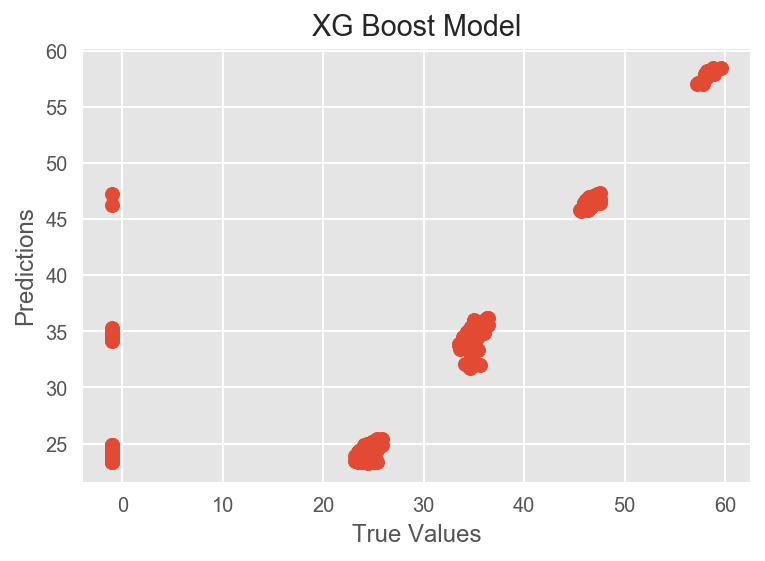

In [779]:
## The line / model
plt.scatter(y_test, xgb_predictions)

plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("XG Boost Model")
plt.show()

## Now rank those predicted times by race and hence predict the winner

In [536]:
# Define function to rank times

def predict_pos(race, df, col_to_rank): 
    test_df = df.loc[df.date_time == race]
    test_df['pred_position'] = test_df[col_to_rank].rank()
    return test_df['pred_position']

In [791]:
# Check the length and make the predicted time column
crayford_to_predict_test['predicted_time'] = xgb_predictions
print len(crayford_to_predict_test), len(xgb_predictions)

2127 2127


/Users/danielpayne/Anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [792]:
# Create a Series object of predicted positions of each race
pred_pos = pd.Series()
for race in crayford_to_predict_test.date_time.unique():
    pred_pos = pred_pos.append(predict_pos(race, crayford_to_predict_test, 'predicted_time'))

/Users/danielpayne/Anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [793]:
# Create the predicted position and hence predicted winner column.
# Then display first race

crayford_to_predict_test['pred_position'] = pred_pos
crayford_to_predict_test['pred_winner'] = crayford_to_predict_test.pred_position.map(lambda x: 1 if x == 1 else 0)
crayford_to_predict_test[['name', 'position', 'winner', 'pred_winner']].head(6)

/Users/danielpayne/Anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/danielpayne/Anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,name,position,winner,pred_winner
13635,Danny Paradise,3.0,0.0,0
13636,Snowdon Stevie,2.0,0.0,0
13637,Millbank Gale,1.0,1.0,1
13638,Clash Tenor,5.0,0.0,0
13639,Jet Stream Turbo,6.0,0.0,0
13640,Ajays Blazer,4.0,0.0,0


## Plot the Confusion Matrix and print the Classification Report

In [555]:
# Function to plot a confusion matrix

import itertools
from sklearn import metrics

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Reds):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [811]:
# Create a table showing results over teh last month
month_test = doggy_test.loc[doggy_test.date_time > '20170615']

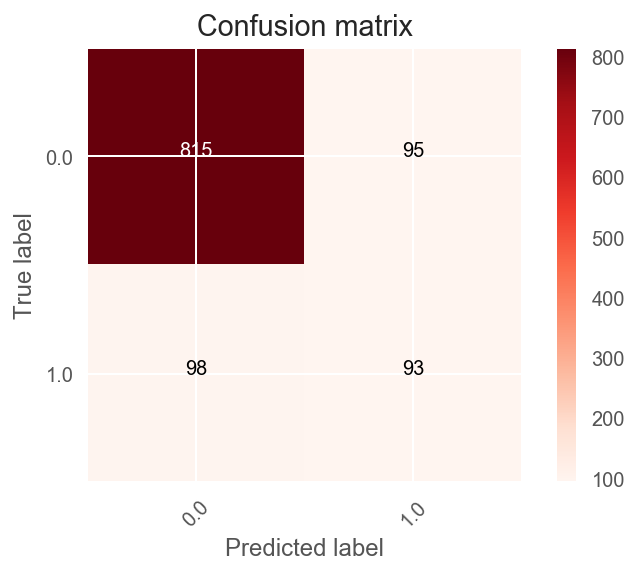

In [812]:
# Display the confustion matrix
conmat = metrics.confusion_matrix(month_test.winner.values, month_test.pred_winner.values)
classes = np.array([ 0.,  1.])
plot_confusion_matrix(conmat, classes)

In [824]:
# Classification Report
class_report = metrics.classification_report(month_test.winner.values, month_test.pred_winner.values)
print class_report

             precision    recall  f1-score   support

          0       0.89      0.90      0.89       910
          1       0.49      0.49      0.49       191

avg / total       0.82      0.82      0.82      1101



## There are race meets on Tuesday, Thursday, Friday and Saturday.

Will compare the race meets in terms of precision

In [855]:
for day in doggy_test.day.unique():
    df = doggy_test.loc[doggy_test.day == day]
    class_report = metrics.classification_report(df.winner.values, df.pred_winner.values)
    print 'The day is:\t', day 
    print class_report

The day is:	Friday
             precision    recall  f1-score   support

          0       0.88      0.88      0.88       949
          1       0.44      0.44      0.44       197

avg / total       0.81      0.81      0.81      1146

The day is:	Saturday
             precision    recall  f1-score   support

          0       0.90      0.90      0.90      2275
          1       0.51      0.50      0.50       475

avg / total       0.83      0.83      0.83      2750

The day is:	Tuesday
             precision    recall  f1-score   support

          0       0.90      0.90      0.90       965
          1       0.50      0.49      0.50       200

avg / total       0.83      0.83      0.83      1165

The day is:	Thursday
             precision    recall  f1-score   support

          0       0.86      0.86      0.86       205
          1       0.33      0.33      0.33        43

avg / total       0.77      0.77      0.77       248



### As there are two race on the Saturday, I will need to split these out

I will make a small function to distinguish this and then print the results out for each race meeting

In [997]:
def race_meet(row):
    if row['day'] == 'Tuesday':
        return 'Tuesday'
    elif row['day'] == 'Thursday':
        return 'Thursday'
    elif row['day'] == 'Friday':
        return 'Friday'
    elif (row['day'] == 'Saturday') & (row['hour'] < 15):
        return 'Saturday AM'
    elif (row['day'] == 'Saturday') & (row['hour'] > 15):
        return 'Saturday PM'

In [998]:
# Make the column
doggy_test['Meet'] = doggy_test.apply(race_meet, axis=1)

In [999]:
# Make the classification report for each race meeting
for meet in doggy_test.Meet.unique():
    df = doggy_test.loc[doggy_test.Meet == meet]
    class_report = metrics.classification_report(df.winner.values, df.pred_winner.values)
    print 'The day is:\t', meet 
    print class_report

The day is:	Friday
             precision    recall  f1-score   support

          0       0.88      0.88      0.88       949
          1       0.44      0.44      0.44       197

avg / total       0.81      0.81      0.81      1146

The day is:	Saturday AM
             precision    recall  f1-score   support

          0       0.89      0.89      0.89      1740
          1       0.47      0.47      0.47       360

avg / total       0.82      0.82      0.82      2100

The day is:	Saturday PM
             precision    recall  f1-score   support

          0       0.91      0.92      0.92       535
          1       0.62      0.60      0.61       115

avg / total       0.86      0.86      0.86       650

The day is:	Tuesday
             precision    recall  f1-score   support

          0       0.90      0.90      0.90       965
          1       0.50      0.49      0.50       200

avg / total       0.83      0.83      0.83      1165

The day is:	Thursday
             precision    recall

### A comparison by race distance

In [1000]:
for dist in doggy_test.distance.unique():
    df = doggy_test.loc[doggy_test.distance == dist]
    class_report = metrics.classification_report(df.winner.values, df.pred_winner.values)
    print 'The day is:\t', dist 
    print class_report

The day is:	380.0
             precision    recall  f1-score   support

          0       0.89      0.89      0.89      3465
          1       0.46      0.46      0.46       720

avg / total       0.81      0.81      0.81      4185

The day is:	540.0
             precision    recall  f1-score   support

          0       0.90      0.90      0.90       750
          1       0.54      0.54      0.54       158

avg / total       0.84      0.84      0.84       908

The day is:	714.0
             precision    recall  f1-score   support

          0       0.92      0.93      0.93       169
          1       0.65      0.63      0.64        35

avg / total       0.88      0.88      0.88       204

The day is:	874.0
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        10
          1       1.00      1.00      1.00         2

avg / total       1.00      1.00      1.00        12



### Finally a comparision by race grade

In [856]:
for day in doggy_test.grade.unique():
    df = doggy_test.loc[doggy_test.grade == day]
    class_report = metrics.classification_report(df.winner.values, df.pred_winner.values)
    print 'The day is:\t', day 
    print class_report

The day is:	A8
             precision    recall  f1-score   support

          0       0.87      0.87      0.87       780
          1       0.37      0.37      0.37       163

avg / total       0.78      0.78      0.78       943

The day is:	H2
             precision    recall  f1-score   support

          0       0.88      0.88      0.88        66
          1       0.43      0.43      0.43        14

avg / total       0.80      0.80      0.80        80

The day is:	A4
             precision    recall  f1-score   support

          0       0.88      0.88      0.88       308
          1       0.41      0.41      0.41        64

avg / total       0.80      0.80      0.80       372

The day is:	S7
             precision    recall  f1-score   support

          0       0.90      0.90      0.90       110
          1       0.52      0.52      0.52        23

avg / total       0.83      0.83      0.83       133

The day is:	A5
             precision    recall  f1-score   support

          0